In [121]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import keras
from keras.datasets import cifar10, mnist
from IPython.display import clear_output
from matplotlib.patches import Ellipse

(60000, 28, 28, 1)


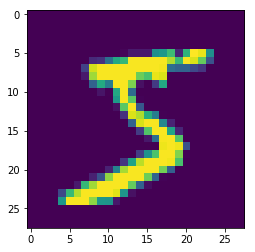

In [35]:
# Get the cifar10 dataset ready
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train,3)

print(x_train.shape)
plt.imshow(x_train[0][:,:,0])
plt.show()

In [192]:
def sample_z_plane(vae, sess:tf.Session, axis_steps:int=20):
    output = []
    b = []
    rows = []
    z = np.zeros((vae.batch_size, vae.z_dim))
    i=1
    for x in np.linspace(-1,1, axis_steps):
        row = []
        for y in np.linspace(-1,1,axis_steps):
            z[0] = [ x,y ]
            y_pred = sess.run(vae.y_form_z, feed_dict={vae.z_input: z})
            row.append(y_pred[0,:,:,0])
        row_img = np.concatenate( [  row[i] for i in range(0,len(row))  ], axis=1 )
        rows.append(row_img)
    img = np.concatenate([ rows[i] for i in range(0,len(rows)) ], axis=0)
    return img


def get_hsv(n:int):
    h = np.linspace(0,255, num=n).astype(np.uint8)
    hsv = np.expand_dims(np.stack([ h, [255]*n, [255]*n  ], axis=1),0).astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)[0]

def show_labeled_z_for_batch(z,z_sigma, batch_y):
    cmap = get_hsv(10)
    
    for i in range(0, z.shape[0]):
        plt.plot( z[i,0], z[i,1] , '.')
        plt.text( z[i,0], z[i,1], '{}'.format(batch_y[i]) )
        
        
        plt.gcf().gca().add_artist( Ellipse(xy=z[i,0:2], width=3*z_sigma[i,0], height=3*z_sigma[i,1], alpha=0.3, color=cmap[batch_y[i],:]/255 )   )
    plt.grid()
    plt.xlabel('z0')
    plt.axis('equal')
    plt.ylabel('z1')
    plt.show()



In [162]:
class VAE:
    def __init__(self, batch_size:int=16, kbase:int=512, layers:int=3, use_batchnorm:bool=False, input_dim:tuple=(28,28,1), z_dim:int=2, sampling_eps_std:float=1, train_drop_rate:float=0.3, name:str='VAE'):
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.input_dim = input_dim
        self.name = name
        self.use_batchnorm = use_batchnorm
        self.layers = layers
        self.sampling_eps_std = sampling_eps_std
        self.train_drop_rate = train_drop_rate
        self.kbase = kbase
        self.build_model()
        
    def dense(self, input, units:int, use_bias:bool=True, use_batchnorm:bool=True, use_activation:bool=True, stddev=0.01, name:str='fc'):
        with tf.variable_scope(name) as scope:
            w_init = tf.contrib.layers.variance_scaling_initializer()
            x = input
            if use_batchnorm:
                x = tf.layers.batch_normalization(x)
            x = tf.layers.dense(x, units, use_bias=use_bias, kernel_initializer=w_init)
            if use_activation:
                x = tf.nn.tanh(x)
            return x
            
    def encoder(self, input, layers:int=3, reuse:bool=False, name:str='encoder'):
        with tf.variable_scope(name) as scope:
            if reuse:
                scope.reuse_variables()
                
            input_shape = input.get_shape()
            print('Input shape: {}'.format(input_shape))
            x = tf.reshape(input, shape=[ input_shape[0], np.prod(input_shape[1:]) ], name='x_flat')

            for layer in range(0, layers):
                x = self.dense(x, self.kbase, use_batchnorm=self.use_batchnorm, name='fc{}'.format(layer+1))
                x = tf.nn.dropout(x, self.train_keep_prob, name='fc{}_drop'.format(layer+1))

            z_mean = self.dense(x, units=self.z_dim, use_batchnorm=False, use_activation=False, name='z_mean')
            z_log_sigma = self.dense(x, units=self.z_dim, use_batchnorm=False, use_activation=False, name='z_log_sigma')
            return z_mean, 1e-8+tf.nn.softplus(z_log_sigma)
        
    def decoder(self, input, layers:int=3, reuse:bool=False, name:str='decoder'):
        with tf.variable_scope(name) as scope:
            if reuse:
                scope.reuse_variables()
            x = input
            
            for layer in range(0, layers):
                x = self.dense(x, units=self.kbase, use_batchnorm=self.use_batchnorm, name='fc{}'.format(layer+1))
            
            x = self.dense(x, np.prod(self.input_dim))
            x = tf.reshape(x, shape=[ self.batch_size ] + list(self.input_dim))
            x = tf.nn.sigmoid(x)
            x = tf.clip_by_value(x, 1e-8, 1-1e-8)
            return x
    
    def sampler(self, mean, sigma, reuse:bool=False, name:str='sampler'):
        with tf.variable_scope(name) as scope:
            eps = tf.random_normal(shape=[self.batch_size, self.z_dim], mean=0.0, stddev=self.sampling_eps_std, dtype=tf.float32)
            return mean + sigma*eps
        
    def build_model(self):
        with tf.variable_scope(self.name) as scope:
            self.x = tf.placeholder(tf.float32, shape=[self.batch_size] +list(self.input_dim), name='x')
            self.z_input = tf.placeholder(tf.float32, shape=[self.batch_size, self.z_dim], name='z_input')
            self.train_keep_prob = tf.placeholder_with_default(1-self.train_drop_rate, shape=[], name='train_keep_prob')

            # X->Z
            self.z_mean, self.z_sigma = self.encoder(self.x, layers=self.layers)
            
            # Sample from Z
            self.z_sampled = self.sampler(self.z_mean, self.z_sigma)
            
            # Z->Y
            self.y = self.decoder(self.z_sampled, layers=self.layers)
            self.y_form_z = self.decoder(self.z_input, layers=self.layers, reuse=True)

            self.ae_loss = tf.reduce_mean(tf.reduce_sum(tf.pow(self.y-self.x,2), axis=[3,2,1]), axis=0)
            self.z_mean_magn = tf.reduce_mean( tf.reduce_sum( tf.pow(self.z_mean,2),axis=1 ), axis=0 )
            self.z_sigma_magn = tf.reduce_mean( tf.reduce_sum( tf.pow(self.z_sigma,2),axis=1 ), axis=0 )
            
            x_flat = tf.reshape(self.x, [self.batch_size, np.prod(self.input_dim)], name='x_flat')
            y_flat = tf.reshape(self.y, [self.batch_size, np.prod(self.input_dim)], name='y_flat')
            
            marginal_likelihood = tf.reduce_sum( x_flat*tf.log(y_flat) + (1-x_flat)*tf.log(1-y_flat) ,1)
            KL_divergence = 0.5*tf.reduce_sum( tf.square(self.z_mean) + tf.square(self.z_sigma) - tf.log(1e-8 + tf.square(self.z_sigma))-1,1 )

            
            self.loss = -tf.reduce_mean(marginal_likelihood) + tf.reduce_mean(KL_divergence)
            
            self.theta = tf.trainable_variables()
            for t in self.theta:
                print(t)

    def load_weights(self, weights:dict, sess:tf.Session):
        for v in self.theta:
            if( v.name in weights.keys() ):
                print('Loading weights for {}'.format(v.name))
                sess.run( tf.assign( v, weights[v.name] ) )
                
    def get_weights(self, sess:tf.Session):
        weights = dict()
        for v in self.theta:
            weights[v.name] = v.eval() 
        return weights
    
    
                
tf.reset_default_graph()
vae = VAE(batch_size=64, kbase=256, layers=2, use_batchnorm=False)   

Input shape: (64, 28, 28, 1)
<tf.Variable 'VAE/encoder/fc1/dense/kernel:0' shape=(784, 256) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc1/dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc2/dense/kernel:0' shape=(256, 256) dtype=float32_ref>
<tf.Variable 'VAE/encoder/fc2/dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_mean/dense/kernel:0' shape=(256, 2) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_mean/dense/bias:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_log_sigma/dense/kernel:0' shape=(256, 2) dtype=float32_ref>
<tf.Variable 'VAE/encoder/z_log_sigma/dense/bias:0' shape=(2,) dtype=float32_ref>
<tf.Variable 'VAE/decoder/fc1/dense/kernel:0' shape=(2, 256) dtype=float32_ref>
<tf.Variable 'VAE/decoder/fc1/dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'VAE/decoder/fc2/dense/kernel:0' shape=(256, 256) dtype=float32_ref>
<tf.Variable 'VAE/decoder/fc2/dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variabl

In [ ]:
vae_optim = tf.train.RMSPropOptimizer(0.001).minimize( vae.loss, var_list=vae.theta)
it = 0
progress = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    vae.load_weights(weights, sess)
    
    while True:
        idx = np.random.uniform(0, x_train.shape[0], size=(vae.batch_size,)).astype(np.int32)
        batch_x = x_train[idx]/255
        batch_y = y_train[idx]

        _, loss_cur = sess.run([ vae_optim, vae.loss ], feed_dict={ vae.x:batch_x })
        print(loss_cur)
        progress.append([ it, loss_cur ])
        
        if it %500==0:
            weights = vae.get_weights(sess)
            
            img = sample_z_plane(vae, sess)
            y_pred,z,z_sigma = sess.run( [vae.y, vae.z_mean, vae.z_sigma] , feed_dict={ vae.x:batch_x, vae.train_keep_prob:1.0})
            
            clear_output()
            
            plt.figure(figsize=(10,10))
            plt.imshow(img, cmap='gray')
            plt.show()
            
            plt.imshow(  (np.concatenate([  batch_x[0][:,:,0], y_pred[0][:,:,0]], axis=1)*255).astype(np.uint8) , cmap='gray' )
            plt.show()
            
            show_labeled_z_for_batch(z,z_sigma, batch_y)
            
            p = np.array(progress)
            p = p[np.max([0, p.shape[0]-2000]):]
            plt.plot( p[:,0], p[:,1] )
            plt.grid()
            plt.show()
        
        it+=1
        
        

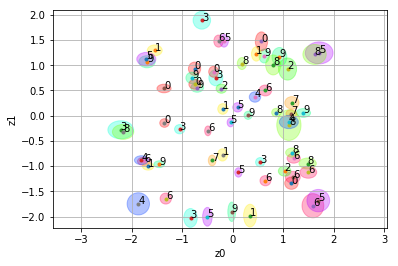

[-1. -1.]
(28, 28, 1)


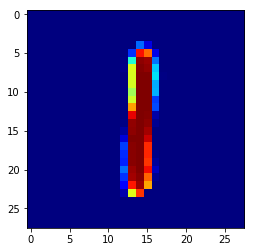

In [145]:

    
cmap = get_hsv(10)
print(cmap.shape)



(10, 3)
